In [22]:
from skimage import io

import skimage.filters as skif
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [35]:
import os

import numpy as np
import torch
import torchvision.transforms as t
from PIL import Image
from skimage import io
from skimage.filters.rank import maximum
from skimage.measure import label
from skimage.morphology import binary_dilation, dilation, disk, square
from skimage.segmentation import expand_labels
from torch.utils.data import ConcatDataset, DataLoader, Dataset


def expand_wide_fractures_gt(img, gt, disk_size=2, thresh=30, gt_thresh=100, gt_ext='png'):
    """
    Expand the ground truth (gt) mask to include wide fractures in the image.
    This function uses a maximum filter to identify large areas of dark pixels in the image,
    and then dilates the gt mask to include these areas. The function also checks for spatial
    contiguity with the gt mask, and only keeps objects that are spatially contiguous with
    objects in the gt mask.

    Parameters
    -----------
    img (numpy.ndarray): The input image.
    gt (numpy.ndarray): The ground truth mask.
    disk_size (int): The size of the disk used for morphological operations.
    thresh (int): The threshold value for the maximum filter.
    gt_thresh (int): The threshold value for the ground truth mask.
    gt_ext (str): The file extension for the ground truth mask.

    Returns
    -----------
    numpy.ndarray: The expanded ground truth mask.
    Thanks to Sam Thiele
    """
    gray = img[...,1] # convert to greyscale (use green channel so vegetation is not so dark)
    imax = maximum( gray, disk(disk_size)) # use a maximum filter to only keep large areas of dark pixels
    #thresh = np.min(imax) * tmul # threshold based on the minimum remaining value in the image
    msk = binary_dilation( imax < thresh, disk(disk_size)) # dilate again after threshold to "re-fill" the dark areas
    
    # add in gt again
    gtg = np.logical_or( msk, gt > gt_thresh )
    
    # only keep objects that are spatially contiguous with objects in the gt
    labeled_components, num_components = label(gtg, connectivity=1, return_num=True)
    overlap_check = []
    for component_id in range(1, num_components + 1): # Check overlap with gt
        component_mask = labeled_components == component_id
        if not np.any(gt[component_mask] > gt_thresh):
            gtg[component_mask] = 0

    if 'tif' in gt_ext:
        new_gt = np.array(gt*255, dtype=np.uint8) | np.array(gtg*255, dtype=np.uint8)
    else:
        new_gt = np.array(gt, dtype=np.uint8) | np.array(gtg*255, dtype=np.uint8)
    return new_gt


def dilate_labels(image):
    """
    Apply multi-scale dilation to labeled regions in an image.

    This function expands labeled regions in a segmented image and applies
    three levels of morphological dilation using structuring elements of increasing sizes.
    Each dilation mask is added to the original expanded image with decreasing weights.

    Parameters
    ------------
    image (np.ndarray): The input image

    Returns
    ------------
    np.ndarray: The image with smoothed label boundaries.
    """
    # Expand labeled regions to fill small gaps between labels
    expanded = expand_labels(image, distance=2)

    # Perform three levels of dilation and create masks for each scale
    dilated_mask_1 = dilation(expanded, square(5)) ^ expanded
    dilated_mask_2 = dilation(expanded, square(9)) ^ dilated_mask_1 ^ expanded
    dilated_mask_3 = dilation(expanded, square(12)) ^ dilated_mask_2 ^ dilated_mask_1 ^ expanded

    # Blend the original and dilated masks with decreasing influence
    blended = expanded + dilated_mask_1 / 3 + dilated_mask_2 / 5 + dilated_mask_3 / 9

    # Convert to unsigned 8-bit integer format for compatibility
    output = np.array(blended, dtype=np.uint8)

    return output

In [1]:
from scipy.optimize import minimize, rosen, rosen_der

In [10]:
img = io.imread('../data/test_ovas/kl5/kl5-s3.png')[:, :, 1]
gt = io.imread('../data/test_ovas/kl5/kl5-s3-gt.tif')

In [11]:
img.shape, gt.shape

((2560, 2560), (2560, 2560))

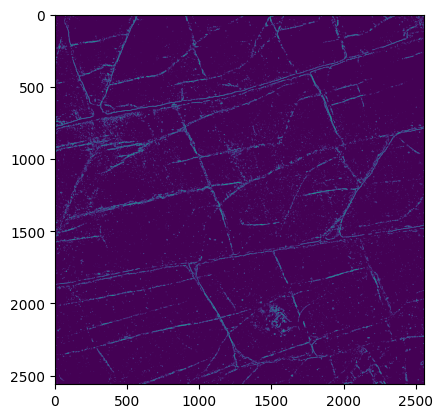

In [20]:
sobimg = skif.sobel(img)
plt.imshow(sobimg > .2)

In [58]:
def func(x):
    img = io.imread('../data/test_ovas/kl5/kl5-s3.png')
    gt = io.imread('../data/test_ovas/kl5/kl5-s3-gt.tif')
    
    gt = expand_wide_fractures_gt(img[:, :, :3].astype(np.uint8), gt)
    gt = dilate_labels(gt)
    gt >= .01
    
    sobimg = skif.sobel(img[:, :, 1]) > x
    f1 = f1_score(gt, sobimg, average='micro')
    return 1 - f1

In [59]:
func(.2)

0.8211062438001594

In [60]:
res = minimize(func, .2, method='Nelder-Mead', tol=1e-6)
res.x

array([0.15961914])

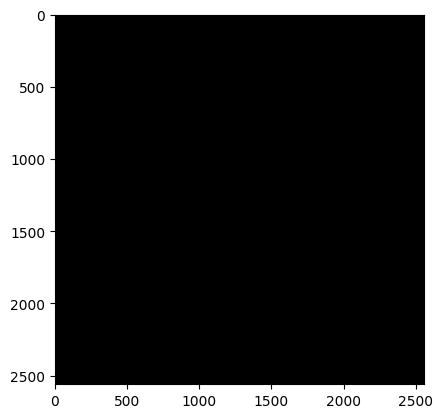

In [41]:
plt.imshow(sobimg > 1, cmap='gray')

In [47]:
img = io.imread('../data/test_ovas/kl5/kl5-s3.png')
gt = io.imread('../data/test_ovas/kl5/kl5-s3-gt.tif')

gt = expand_wide_fractures_gt(img[:, :, :3].astype(np.uint8), gt)
gt = dilate_labels(gt)
gt >= .01

sobimg = skif.sobel(img[:, :, 1]) > 1

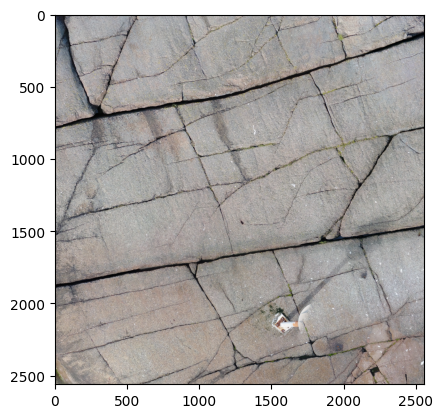

In [48]:
plt.imshow(img)

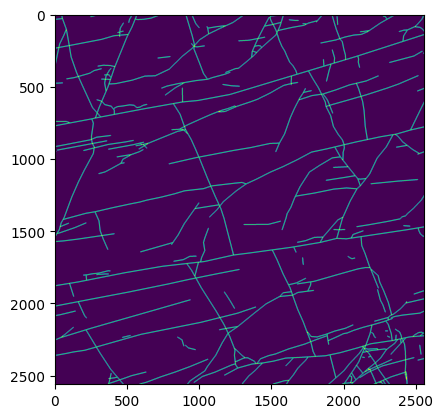

In [49]:
plt.imshow(gt)

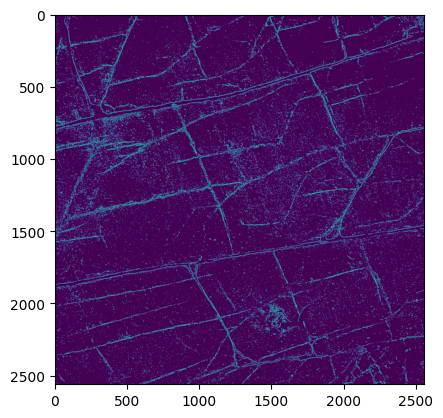

In [61]:
plt.imshow(skif.sobel(img[:, :, 1]) > 0.15961914)